# MEDICAL APPOINTMENT NO SHOWS IN BRAZIL

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This analysis sourced a dataset from <a href=https://www.kaggle.com/joniarroba/noshowappointments>Kaggle</a> to look at which medical appointments in Brazil were more likely to result in a patient no-show.

In [63]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [64]:
import numpy as np
import pandas as pd

import datetime
from datetime import datetime, date

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# changes figure size for all figures
mpl.rcParams['figure.figsize'] = [9,9]

<a id='wrangling'></a>
## Data Wrangling

Example of Records in Dataset before Cleaning:

In [65]:
appts = pd.read_csv('KaggleV2-May-2016.csv', index_col='AppointmentID')
appts.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
AppointmentID,,,,,,,,,,,,,
5642903,2.987250e+13,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
5642503,5.589978e+14,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
5642549,4.262962e+12,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
5642828,8.679512e+11,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
5642494,8.841186e+12,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Number of Rows:

In [66]:
len(appts)

110527

Before exploring the dataset, I cleaned up some issues in the data:
<ul>
<li><u>Patient Id's:</u> Five patient Id's contained decimal points in the middle. Assuming these were data entry errors, I removed the periods, then converted all Id's into integers.</li>
<li><u>Ages:</u> One of the ages was listed as -1. It's possible this represented a fetus, but it seemed unlikely because it was the only negative value. I changed the value to NaN so that it doesn't affect calculations of ages.</li> 
<li><u>Dates:</u>
    <ul>
    <li>I converted the data from the two date columns into the datetime datatype.</li>
    <li>I separated the data into just dates and just times. Since there's no information on appointment time, I ignored this.</li>
    <li>I created a new column with number of days between when a person scheduled an appointment and the date of the appointment.</li>
    </ul>
</ul>

In [67]:
# 
# Steps to Find Issues:
#
# These are not printed to avoid cluttering report.

appts.dtypes
# Issue 1: PatientId is float64.
# Issue 2: ScheduledDay & AppointmentDay are not datetime objects.

len(appts[appts.PatientId % 1 != 0])
# Issue 3: PatientId has 5 items with decimals in the middle.

min(appts.Age)
len(appts[appts.Age < 0])
# Issue 4: Minimum age is -1. This is only the case in a single record.

appts.isnull().sum()
# No problems. No item's value is NaN.

appts.index.nunique() == len(appts)
# No problems. The above is true, so all values in the index are unique.

# 
# Steps to Correct Issues:
#

# Cleaning PatientId column (issues 1 & 3)
appts.PatientId = appts.PatientId.astype(str)      # convert to str   
appts.PatientId.replace(regex=True,inplace=True,   # remove . chars
                        to_replace=r'\.',value='') 
appts.PatientId = appts.PatientId.astype(int)      # convert to int

# Cleaning Age column (issue 4)
appts.Age = appts.Age.replace(-1, np.nan)  # replaces -1 with NaN

# Modifying ScheduledDay & AppointmentDay columns
# convert SchedulingDate to datetime; extract date for new column
appts['SchedulingDate'] = pd.to_datetime(
    appts.ScheduledDay, infer_datetime_format=True).dt.date
# convert SchedulingDate to datetime; extract time for new column
appts['SchedulingTime'] = pd.to_datetime(
    appts.ScheduledDay, infer_datetime_format=True).dt.time
# convert AppointmentDate to datetime; extract date for new column
appts['AppointmentDate'] = pd.to_datetime(
    appts.AppointmentDay, infer_datetime_format=True).dt.date
# create column with # of days between scheduling and appointment date
appts['DaysBetween'] = (appts.AppointmentDate - 
                        appts.SchedulingDate).dt.days
# crop ScheduledDay & AppointmentDay columns, which are in str. format
appts.drop(['ScheduledDay', 'AppointmentDay'], axis=1)

# Rename columns to change spelling and terminology
appts = appts.rename(columns = {
    'Neighbourhood': 'Neighborhood', # American Eng. spelling
    'Hipertension': 'Hypertension',  # changes spelling
    'Handcap': 'Disability',         # changes terminology
    'No-show': 'NoShow'})            # easier to reference column

# Change order of columns
appts = appts[['PatientId', 'Gender', 'SchedulingDate', 'SchedulingTime', 
               'AppointmentDate', 'DaysBetween', 'Age', 'Neighborhood', 
               'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism',
               'Disability', 'SMS_received', 'NoShow']]

# Changes value in NoShow column from string to integer
# 0 = Showed for appointement; 1 = No showed for appointment
appts['NoShow'] = appts['NoShow'].replace('Yes', 1)
appts['NoShow'] = appts['NoShow'].replace('No', 0)

appts.head()

,PatientId,Gender,SchedulingDate,SchedulingTime,AppointmentDate,DaysBetween,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Disability,SMS_received,NoShow
AppointmentID,,,,,,,,,,,,,,,
5642903,298724998242960,F,2016-04-29,18:38:08,2016-04-29,0,62.0,JARDIM DA PENHA,0,1,0,0,0,0,0
5642503,5589977766944380,M,2016-04-29,16:08:27,2016-04-29,0,56.0,JARDIM DA PENHA,0,0,0,0,0,0,0
5642549,42629622999510,F,2016-04-29,16:19:04,2016-04-29,0,62.0,MATA DA PRAIA,0,0,0,0,0,0,0
5642828,8679512131740,F,2016-04-29,17:29:31,2016-04-29,0,8.0,PONTAL DE CAMBURI,0,0,0,0,0,0,0
5642494,88411864481830,F,2016-04-29,16:07:23,2016-04-29,0,56.0,JARDIM DA PENHA,0,1,1,0,0,0,0


<a id='eda'></a>
## Exploratory Data Analysis

Before I asked any questions of the data, I had what might be called a pre-question:

How big a problem are no-shows for medical appointments in Brazil?

In [68]:
# creates df with only no-shows
noshows = appts[appts.NoShow == 1]

print('{:,.2%}'.format(len(noshows) / len(appts)))

20.19%


The answer is that no-shows are a big problem. 

About 20% of medical appointments result in no-shows, creating a signficant challenge for medical providers trying to deliver services efficiently.

So now I want to first get a sense of how the data is distributed for different characteristics, then hone in on individual characteristics and circumstances, to see if any could help predict no-shows.

For example, to check the the number of appointments scheduled based for patients in different age ranges, I plotted a simple histogram chart.

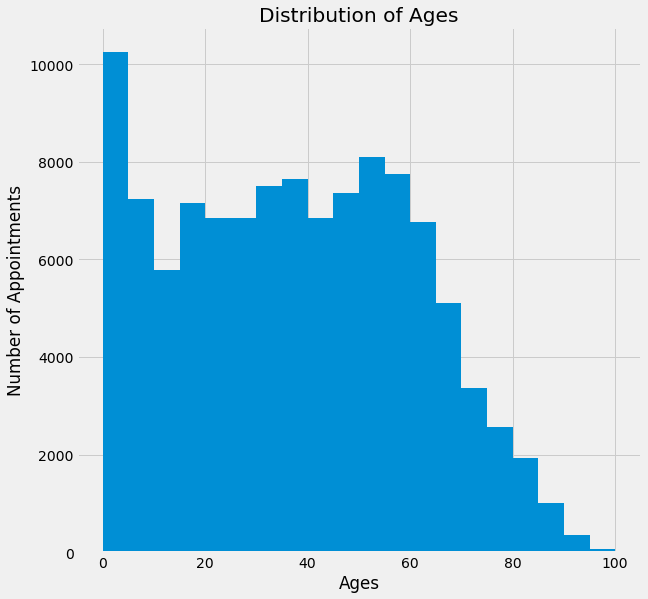

In [69]:
mpl.style.use('fivethirtyeight')

plt.hist(appts.Age, bins=20, range=[0,100])
plt.title('Distribution of Ages')

ax = plt.gca()
ax.set_xlabel('Ages')
ax.set_ylabel('Number of Appointments')

plt.show()

The most common age for patients is between zero and five years old, and the number of patients in each range stays relatively steady until the number begins to decline near age 60.

Now that I have a sense of the age distribution, I want to hone in further and see whether particular genders or ages more likely to no-show?

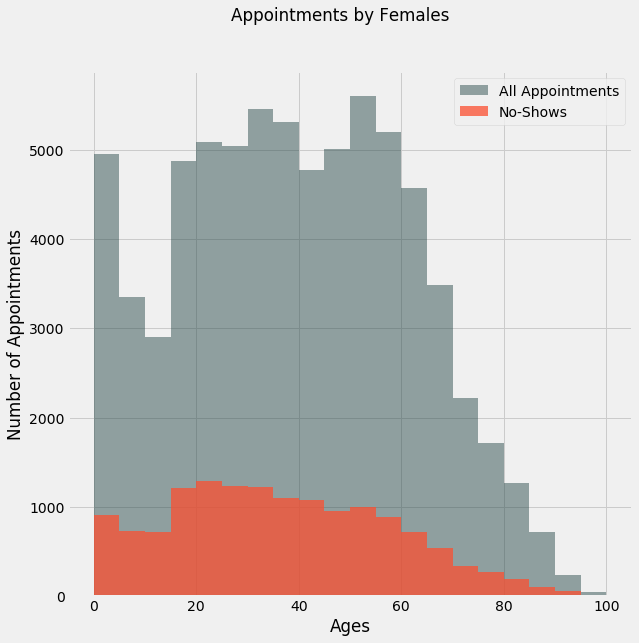

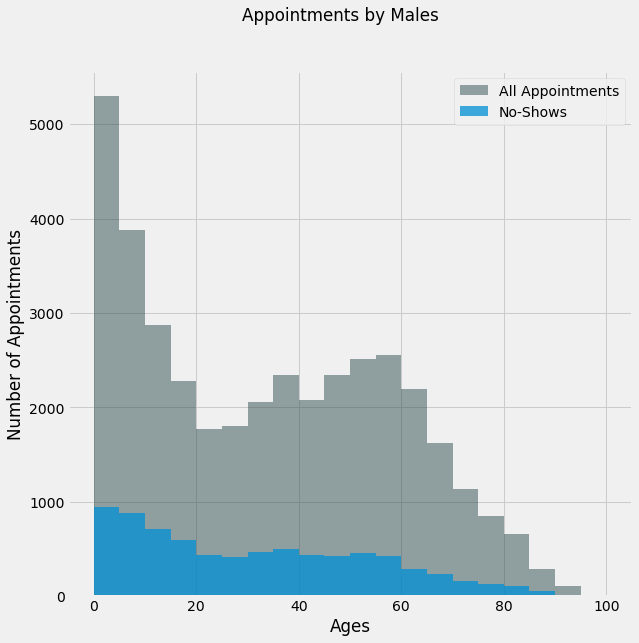

In [70]:
def plot_age_gender(gender, color, fig_title):
    plt.hist(appts[appts.Gender == gender].Age,
             bins=20, range=[0,100],alpha=.5, 
             label='All Appointments', facecolor='darkslategray')
    plt.hist(noshows[noshows.Gender == gender].Age,
             bins=20, range=[0,100], alpha=.75,
             label='No-Shows', facecolor=color)
    plt.legend(loc='upper right')
    plt.suptitle(fig_title)
    ax = plt.gca()
    ax.set_xlabel('Ages')
    ax.set_ylabel('Number of Appointments')
    
    plt.show()

plot_age_gender('F', '#fc4f30', "Appointments by Females")
plot_age_gender('M', '#008fd5', "Appointments by Males")

It's not obvious that age or gender is a major predictor of no-shows. Ages with more total appointments also have more no-shows, but that doesn't help us predict no-shows.

Could certain medical conditions more effectively predict no-shows?

I first wanted to see how many appointments were scheduled by patients with each medical condition.

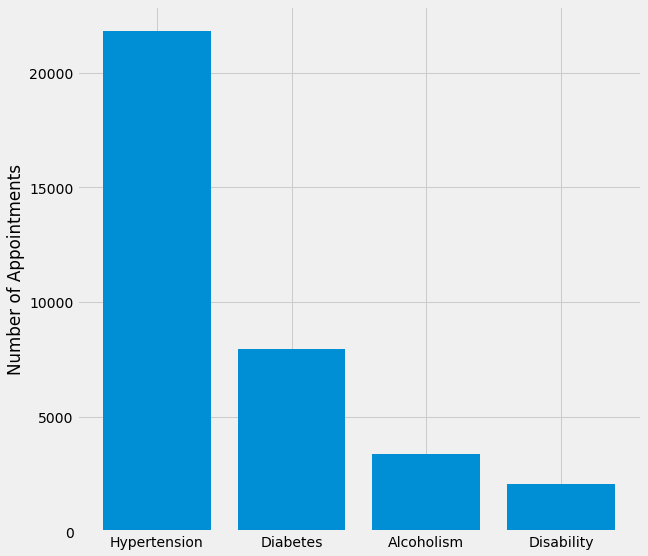

In [71]:
# creates dictionary with patient counts for each condition 
medical_cond = {
    'Hypertension': len(appts[appts.Hypertension == 1]),
    'Diabetes': len(appts[appts.Diabetes == 1]),
    'Alcoholism': len(appts[appts.Alcoholism == 1]),
    'Disability': len(appts[appts.Disability == 1])
}

names = list(medical_cond.keys())
values = list(medical_cond.values())
pos = np.arange(len(names))

# plots number of patients with each condition
plt.bar(pos, values)
plt.xticks(pos, names)
ax = plt.gca()
ax.set_ylabel('Number of Appointments')

plt.show()


Of these four medical conditions, the greatest number of appointments were scheduled for patients with hypertension, followed by diabetes. 

We still need to investigate any possible relationships between medical conditions and the rate of no shows, but just having the counts is useful in order to judge the potential utility of possible approaches to addressing no shows. For example, if patients with hypertension missed appointments at a higher or lower rate than average, that could be very useful information, because there are a lot of patients with hypertension. Conversely, if patients with a disability missed appointments at the same higher or lower rate, that might be less useful, since it would represent a lower total number of no shows. 

With that in mind, I looked at the rate of no shows for each medical condition.

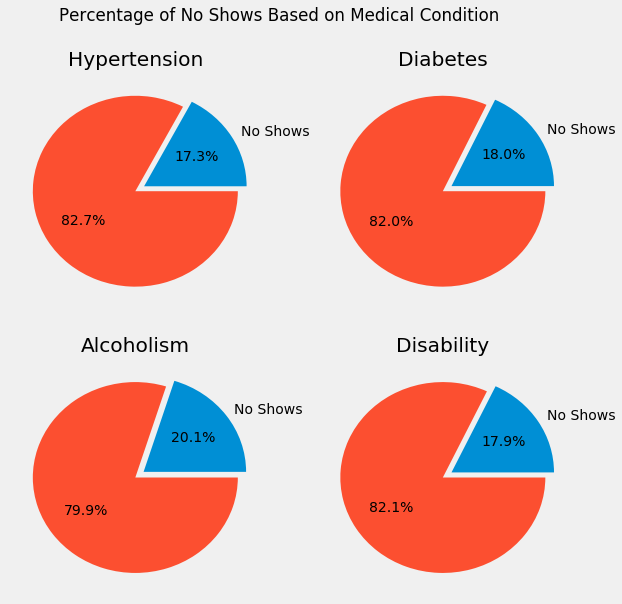

In [72]:
# create df of appointments that were kept
kept_appts = appts[appts.NoShow == 0]

# conditions used in below subplots
labels = ['No Shows', '']
explode = (.1, 0)
autopct = '%1.1f%%'
startangle = 0

def get_sizes(df1, df2, variable):
    sizes = [len(df1[df1[variable] == 1]),
             len(df2[df2[variable] == 1])]
    return sizes

fig, axes = plt.subplots(2, 2)

axes[0,0].pie(get_sizes(noshows, kept_appts, 'Hypertension'), 
              explode=explode, labels=labels, autopct = autopct)
axes[0,0].set_title('Hypertension')
axes[0,1].pie(get_sizes(noshows, kept_appts, 'Diabetes'), 
              explode=explode, labels=labels, autopct = autopct)
axes[0,1].set_title('Diabetes')
axes[1,0].pie(get_sizes(noshows, kept_appts, 'Alcoholism'), 
              explode=explode, labels=labels, autopct = autopct)
axes[1,0].set_title('Alcoholism')
axes[1,1].pie(get_sizes(noshows, kept_appts, 'Disability'), 
              explode=explode, labels=labels, autopct = autopct)
axes[1,1].set_title('Disability')

plt.suptitle('Percentage of No Shows Based on Medical Condition')
plt.show()

We learned earlier that about 20% of appointments in the dataset resulted in no-shows.

Compared to this average, when persons with certain medical conditions make appointments, they are more likely to keep their appointments. Medical conditions associated with people showing up to their appointments include hypertension, diabetes, or a disability.

Appointments by people with alcoholism are no more or no less likely to result in a no-show than the average rate.

Perhaps when predicting no-shows, the characteristics of the patients are less important than the circumstances of the appointments. For example, does the number of days between scheduling an appointment and the appointment's date have any predictive power?

Before investigating that relationship, I first wanted to check how far in advance appointments were typically scheduled.

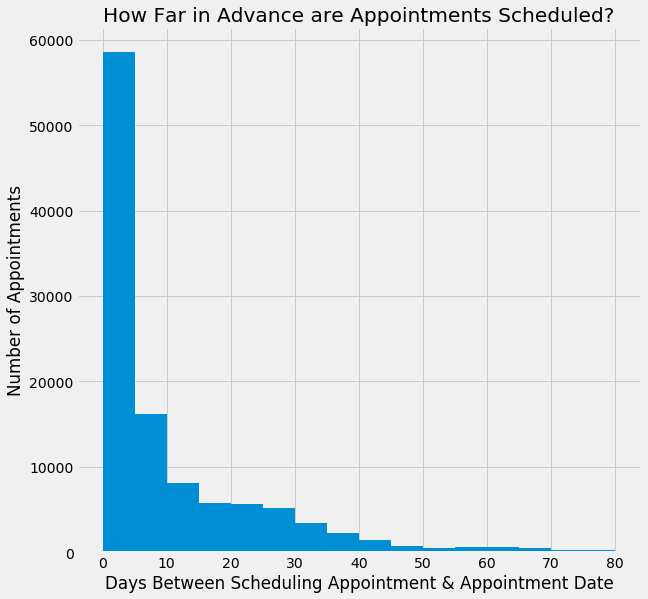

In [73]:
plt.hist(appts.DaysBetween, bins=16, range=[0,80])
plt.title('How Far in Advance are Appointments Scheduled?')

ax = plt.gca()
ax.set_xlabel('Days Between Scheduling Appointment & Appointment Date')
ax.set_ylabel('Number of Appointments')

plt.show()

Most appointments are scheduled between zero and five days in advance. The numbers of appointments scheduled further in advance decline steeply, though there were still several thousand appointments scheduled more than a month in advance.

Now I wanted to return to the question of the relationship between the rate of no shows and the number of days between scheduling an appointment and the appointment's date.

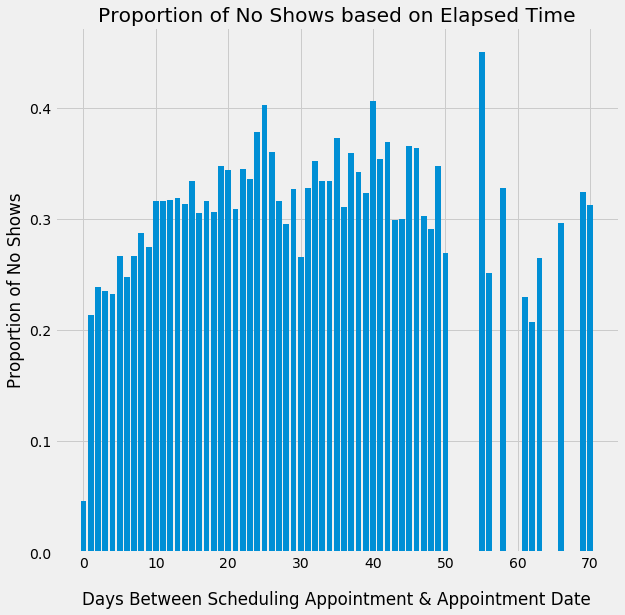

In [74]:
# uses groupby to create two df's
# first df counts how many times each value for DaysBetween occurred
days_counts = appts.groupby('DaysBetween')['DaysBetween'].count()
# second df computes mean of no-shows for each value of DaysBetween
days_means = appts.groupby(['DaysBetween'])['NoShow'].mean()

# first & second df are combined
appts_days = pd.concat([days_counts, days_means], axis=1)
appts_days = appts_days.rename(columns = {
    'DaysBetween': 'Count',
    'NoShow': 'ProportionNoShows'})
# limits df to days with more than 100 entries
# helps limit misleading data from DaysBetween with only a few entries
appts_days_100 = appts_days[appts_days['Count'] > 100]

# creates variables for use in bar plot
index = pd.Series(appts_days_100.index)
y_pos = pd.Series(appts_days_100.ProportionNoShows)

plt.bar(index, y_pos)
plt.xlabel('Days Between Scheduling Appointment & Appointment Date',
          labelpad=20)
plt.ylabel('Proportion of No Shows')
plt.title('Proportion of No Shows based on Elapsed Time')
plt.show()


Here, for the first time, we see a variable that seems to have a lot of predictive potential. 

There are two important take-aways. First, when there are fewer days between scheduling an appointment and the appointment itself, it's less likely the appointment will result in a no-show. We don't know the reason for this trend: perhaps people forget about appointments, or perhaps conflicts arise, or perhaps the reason for the medical appointment resolves itself.

The second important take-away is that very few people don't show up to appointments scheduled for the same day. In an earlier chart, we saw that appointments were commonly scheduled for zero to five days in the future. Now I wanted to look at the numbers in even finer detail. How many same-day appointments were there? And how does that compare to other common values for days between appointments?

The below chart contains the five most common values for days between the scheduling and appointment dates.

In [75]:
appts_days_100.sort_values(by='Count', ascending=False).head()

,Count,ProportionNoShows
DaysBetween,,
0,38563,0.046469
2,6725,0.238216
4,5290,0.232703
1,5213,0.213505
7,4906,0.266816


Wow! About 38,500 of the roughly 110,500 appointments were same-day appointments. That's a high percentage of the total appointments:

In [76]:
print('{:,.2%}'.format(38563 / len(appts)))

34.89%


Since same-day appointments are associated with a very small proportion of no-shows, it might make sense to investigate whether same-day appointments could be part of a solution. Maybe scheduling more same-day appointments could reduce the number of no-shows.

Obviously, this would require much further investigation.

But it also opens up an interesting line of inquiry. Same-day appointments seem to be a major predictor. If we exclude same-day appointments, do other variables play a larger impact?

As a baseline, let's get the percentage of no-shows with at least one day between scheduling the appointment and the appointment itself:

In [77]:
# creates df of appointments with at least 1 day between scheduling & appt.
not_sameday = appts[appts['DaysBetween'] > 0]
# same for no-shows
noshows_not_sameday = noshows[noshows['DaysBetween'] > 0]
# same for kept appointments
kept_appts_not_sameday = kept_appts[kept_appts['DaysBetween'] > 0]

print('{:,.2%}'.format(len(noshows_not_sameday) / len(not_sameday)))

28.52%


About 28.5% of all non-same-day appointments result in no shows. 

What can we learn from revisiting the pie charts of medical conditions, excluding same-day appointments?

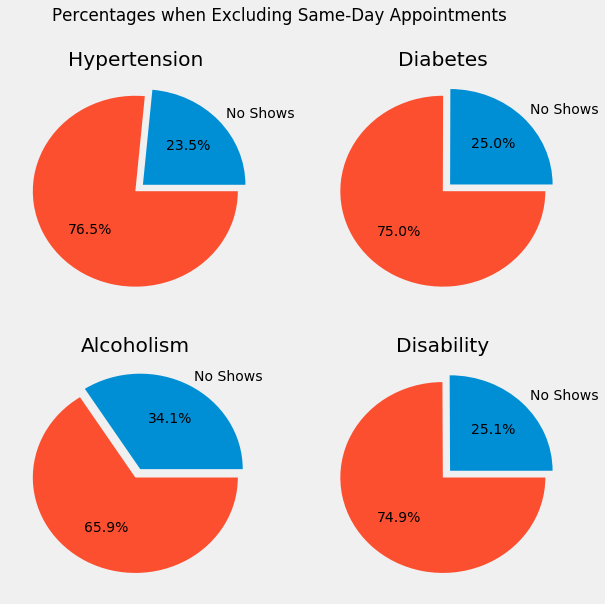

In [78]:
# shortens dataframe names for use in below function only
df1 = noshows_not_sameday.copy()
df2 = kept_appts_not_sameday.copy()

fig, axes = plt.subplots(2, 2)

axes[0,0].pie(get_sizes(df1, df2, 'Hypertension'), 
              explode=explode, labels=labels, autopct = autopct)
axes[0,0].set_title('Hypertension')
axes[0,1].pie(get_sizes(df1, df2, 'Diabetes'), 
              explode=explode, labels=labels, autopct = autopct)
axes[0,1].set_title('Diabetes')
axes[1,0].pie(get_sizes(df1, df2, 'Alcoholism'), 
              explode=explode, labels=labels, autopct = autopct)
axes[1,0].set_title('Alcoholism')
axes[1,1].pie(get_sizes(df1, df2, 'Disability'), 
              explode=explode, labels=labels, autopct = autopct)
axes[1,1].set_title('Disability')

plt.suptitle('Percentages when Excluding Same-Day Appointments')
plt.show()

Now that we've excluded same-day appointments, we see that a patient's alcoholism might help predict no shows. 

Appointments by patients with alcoholism resulted in no shows for non-same-day appointments about 34% of the time, as compared to the 28.5% for non-same-day appointments by everyone.

In contrast, patients with hypertension, diabetes, or a disability resulted in no shows for non-same-day appointments somewhat less frequently than the average for all patients.

Does sending a patient a text message impact the likelihood that they will show up to their non-same-day appointments?

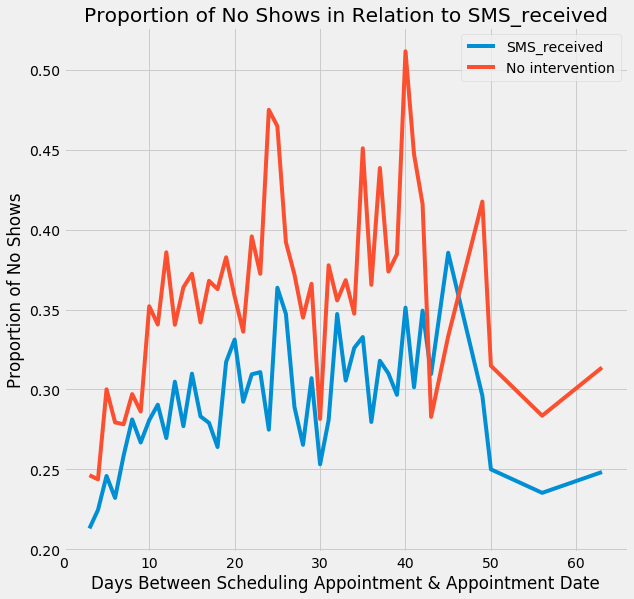

In [79]:
# creates dataframe with all appointments scheduled at least one day prior
appts_non_same_day = appts[appts['DaysBetween'] >= 1]

# Function accepts column with value of 0 or 1.
# It's assumed the variable represents an intervention that may
# impact the likelihood that a patient will show up for an appointment.
# Days-between are on the x-axis.
def plot_days_intervention(intervention):
    days_counts = appts_non_same_day.groupby(
        ['DaysBetween', intervention])['DaysBetween'].count()
    days_means = appts_non_same_day.groupby(
        ['DaysBetween', intervention])['NoShow'].mean()

    # first & second df are combined
    appts_days = pd.concat([days_counts, days_means], axis=1)
    appts_days = appts_days.rename(columns = {
        'DaysBetween': 'Count',
        'NoShow': 'ProportionNoShows'})
    
    # unstacks values associated with 'intervention' variable
    appts_days = appts_days.unstack()
    
    # helps limit misleading data from DaysBetween with only a few records
    appts_robust = appts_days[(appts_days['Count'][0] > 50) &
                              (appts_days['Count'][1] > 50)]
    
    x = pd.Series(appts_robust.index)
    y1 = pd.Series(appts_robust['ProportionNoShows'][1])
    y2 = pd.Series(appts_robust['ProportionNoShows'][0])

    plt.plot(x, y1, label=intervention)
    plt.plot(x, y2, label='No intervention')
    title = str('Proportion of No Shows in Relation to ' + intervention)
    plt.title(title)
    plt.legend()
    ax = plt.gca()
    ax.set_xlabel('Days Between Scheduling Appointment & Appointment Date')
    ax.set_ylabel('Proportion of No Shows')
    plt.show()

plot_days_intervention('SMS_received')

Receiving a SMS message is consistently related a lower incidence of no shows, for almost any number of days between scheduling the appointment and the appointment date. 

We still cannot conclude that sending a SMS message causes the lower incidence of no shows. It's possible that SMS messages are sent to patients in particular circumstances or from particular backgrounds, and those circumstances or backgrounds already predispose the patients to show up more frequently to appointments. 

For example, perhaps SMS messages are sent to patients with the most dangerous medical conditions, and those patients are already more likely to keep their appointments because of the seriousness of their conditions. It would be useful to know why some patients receive SMS messages and others don't, in order to more accurately report on the potential usefulness of using SMS messages with more patients.

SMS messages are only one possible (and seemingly minor) intervention into the lives of patients. Brazil also has a social welfare program, which this dataset calls a scholarship, referred to as [Bolsa Familia](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia), that gives poorer families financial aid if they meet certain conditions&mdash;such as vaccinating their children and ensuring their children's attendance at school.

Does this larger intervention into the lives of patients correlate with less freqent no-shows?

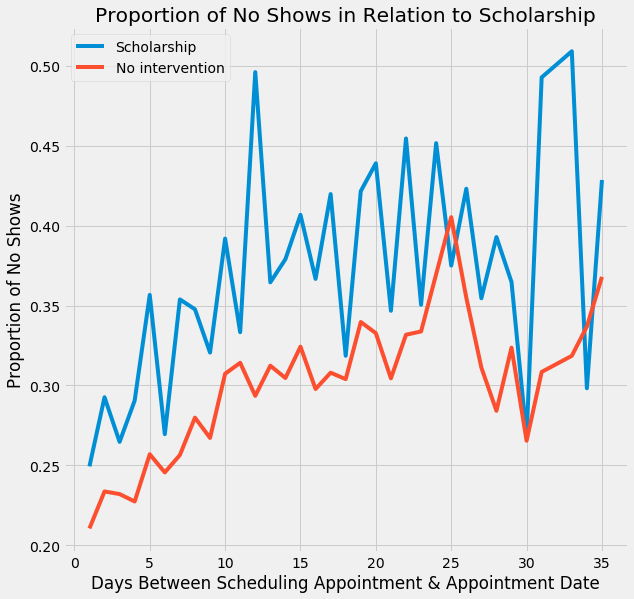

In [80]:
plot_days_intervention('Scholarship')

It turns out that the opposite is true&mdash;recipients of the Bolsa Familia scholarship more frequently missed appointments, regardless of how many days passed between scheduling the appointment and the appointment date.

Again, this doesn't tell us causation. We don't know whether the recipients of the Bolsa Familia scholarship were already predisposed to no show appointments more frequently, or what impact the Bolsa Familia scholarship had on the incidence of no shows.

It might be informative to compare the rate of no shows by Bolsa Familia recipients to the rate of no shows for patients from similar financial backgrounds. However, this dataset does not contain information on patients' financial backgrounds, so that analysis is presently beyond the reach of this report.

<a id='conclusions'></a>
## Conclusions

Based on this dataset, about 20% of medical appointments in Brazil result in no shows. The above analysis looked for potential factors that may influence the likelihood of no shows. The analysis investigated correlations, and was necessarily unable to make conclusions about causation. The analysis revealed the following factors may be correlated:

<ul>
<li>Patients with same-day appointments, or appointments scheduled for only a day or two in the future, keep their appointments more frequently.</li>
<li>Patients who suffer from alcoholism more frequently miss appointments that are not scheduled for the same day.</li> 
<li>Patients who receive SMS messages more frequently keep their appointments. This is true whether the appointment is scheduled for 1 day in the future or 1 month in the future.</li>
<li>Patients who receive the Bolsa Familia scholarship more frequently miss their appointments. (Again, it wasn't possible to compare Bolsa Familia recipients only to patients from similar financial backgrounds due to limitations in the dataset.)</li>
</ul>

This analysis cannot conclude that any of these factors caused the higher or lower rates of no shows for these patients. For that reason, it would likely be inappropriate to base decisions on any of these factors, particularly if doing so punished patients based on their characteristics rather than their actions. For example, it would be problematic to treat patients with alcoholism differently from other patients when scheduling appointments.

Still, this analysis does provide a few potential avenues for further investigation. It may be useful to investigate whether more medical services can be provided to patients on the day they schedule appointments or within the next day or two. Determining whether or not such a change would even be feasible requires an understanding of medicine and the medical system in Brazil that is beyond the scope of this analysis.

It likely makes sense to first investigate an avenue for possible improvements that wouldn't require such a large change in the medical system&mdash;namely, sending SMS messages. If sending SMS messages to patients is not burdensome, it may make sense to try sending SMS messages to more patients and tracking whether the rate of no shows declines.